In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
import os
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
model_path = "data/models/a5_tseries_model_2hr.h5"
bed_path = "data/a5/tseries/2hr/1000_around_summits.bed.gz"

In [3]:
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [4]:
from keras.models import load_model
from keras.utils import CustomObjectScope

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model('/users/amr1/pho4/data/models/a5_tseries_model_2hr.h5')







Instructions for updating:
Use `tf.cast` instead.


In [5]:
seq_len = 1346
out_pred_len = 1000
inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="/users/amr1/pho4/data/genome/hg38/hg38.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len),
      coordstovals.bigwig.PosAndNegSmoothWindowCollapsedLogCounts(
        pos_strand_bigwig_path="/users/amr1/pho4/data/a5/tseries/2hr/ctl/control_pos_strand.bw",
        neg_strand_bigwig_path="/users/amr1/pho4/data/a5/tseries/2hr/ctl/control_neg_strand.bw",
        counts_mode_name="control_logcount",
        profile_mode_name="control_profile",
        center_size_to_use=out_pred_len,
        smoothing_windows=[1,50])])

targets_coordstovals = coordstovals.bigwig.PosAndNegSeparateLogCounts(
    pos_strand_bigwig_path="/users/amr1/pho4/data/a5/tseries/2hr/pos_strand.bw",
    neg_strand_bigwig_path="/users/amr1/pho4/data/a5/tseries/2hr/neg_strand.bw",
    counts_mode_name="task0_logcount",
    profile_mode_name="task0_profile",
    center_size_to_use=out_pred_len)

In [6]:
keras_data_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file=bed_path,
            batch_size=128,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer


In [7]:
import shap
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in [0]:
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    to_return.append(np.zeros_like(orig_inp[1]))
    return to_return

def shuffle_several_times(s):
    numshuffles=20
    return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
            np.array([s[1] for i in range(numshuffles)])]

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[1]],
     tf.reduce_sum(model.outputs[0],axis=-1)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

#See Google slide deck for explanations
#We meannorm as per section titled "Adjustments for Softmax Layers"
# in the DeepLIFT paper
meannormed_logits = (
    model.outputs[1]-
    tf.reduce_mean(model.outputs[1],axis=1)[:,None,:])
#'stop_gradient' will prevent importance from being propagated through
# this operation; we do this because we just want to treat the post-softmax
# probabilities as 'weights' on the different logits, without having the
# network explain how the probabilities themselves were derived
#Could be worth contrasting explanations derived with and without stop_gradient
# enabled...
stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
softmax_out = tf.nn.softmax(stopgrad_meannormed_logits,axis=1)
#Weight the logits according to the softmax probabilities, take the sum for each
# example. This mirrors what was done for the bpnet paper.
weightedsum_meannormed_logits = tf.reduce_sum(softmax_out*meannormed_logits,
                                              axis=(1,2))
profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
    ([model.input[0], model.input[2]],
     weightedsum_meannormed_logits),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

In [8]:
test_seqs = []
test_biastrack_logcount = []
test_biastrack_profile = []
test_labels_logcount = []
test_labels_profile = []
for batch_idx in range(len(keras_data_batch_generator)):
    batch_inputs, batch_labels = keras_data_batch_generator[batch_idx]
    test_seqs.append(batch_inputs['sequence'])
    test_biastrack_logcount.append(batch_inputs['control_logcount'])
    test_biastrack_profile.append(batch_inputs['control_profile'])
    test_labels_logcount.append(batch_labels['task0_logcount'])
    test_labels_profile.append(batch_labels['task0_profile'])
test_biastrack_logcount = np.concatenate(test_biastrack_logcount, axis=0)
test_biastrack_profile = np.concatenate(test_biastrack_profile,axis=0)
test_seqs = np.concatenate(test_seqs,axis=0)
test_labels_logcount = np.concatenate(test_labels_logcount, axis=0)
test_labels_profile = np.concatenate(test_labels_profile, axis=0)

In [9]:
test_labels_logtotalcount = np.log(np.sum(np.exp(test_labels_logcount) - 1,axis=-1) + 1)
sorted_test_indices = [x[0] for x in 
                       sorted(enumerate(test_labels_logtotalcount),
                              key=lambda x: -x[1])]

In [10]:
new_seqs = []
for idx in range(0, 2500):
    new_seqs.append(test_seqs[sorted_test_indices[idx]])
new_seqs = np.array(new_seqs)

In [11]:
#The shap scores
post_counts_hypimps,_ = profile_model_counts_explainer.shap_values(
    [new_seqs, np.zeros((len(new_seqs), 1))],
    progress_message=10)
post_profile_hypimps,_ = profile_model_profile_explainer.shap_values(
    [new_seqs, np.zeros((len(new_seqs), out_pred_len, 2))],
    progress_message=10)

post_counts_actualimps = post_counts_hypimps*new_seqs
post_profile_actualimps = post_profile_hypimps*new_seqs

Done 0 examples of 2500
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Done 10 examples of 2500
Done 20 examples of 2500
Done 30 examples of 2500
Done 40 examples of 2500
Done 50 examples of 2500
Done 60 examples of 2500
Done 70 examples of 2500
Done 80 examples of 2500
Done 90 examples of 2500
Done 100 examples of 2500
Done 110 examples of 2500
Done 120 examples of 2500
Done 130 examples of 2500
Done 140 examples of 2500
Done 150 examples of 2500
Done 160 examples of 2500
Done 170 examples of 2500
Done 180 examples of 2500
Done 190 examples of 2500
Done 200 examples of 2500
Done 210 examples of 2500
Done 220 examples of 2500
Done 230 examples of 2500
Done 240 examples of 2500
Done 250 examples of 2500
Done 260 examples of 2500
Done 270 examples of 2500
Done 280 examples of 2500
Done 290 examples of 2500
Done 300 examples of 2500
Done 310 examples of 2500
Done 320 examples of 2500
Done 330 examples of 2500
Done 340 examples of 2500
Done 35

idx 6558
Counts [1160. 1207.]
oneovertemp 1.0
(1000, 2)


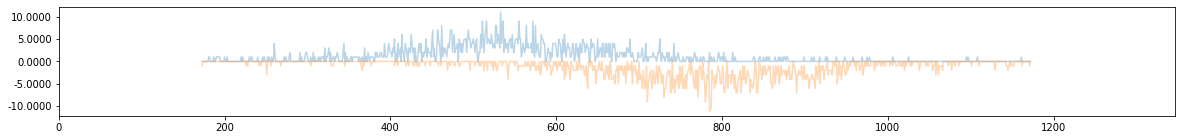

counts imp


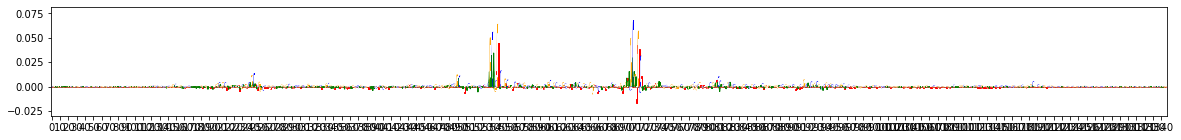

profile imp


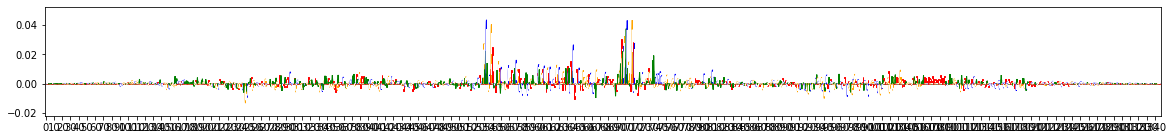

idx 2006
Counts [1160. 1128.]
oneovertemp 1.0
(1000, 2)


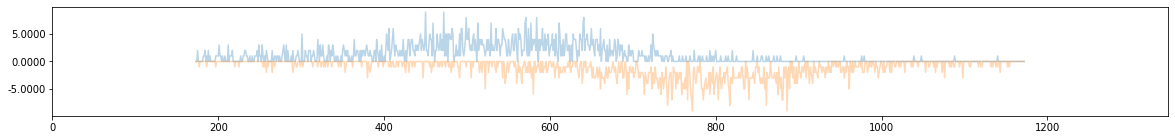

counts imp


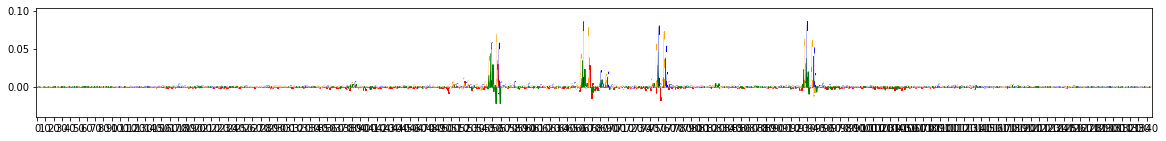

profile imp


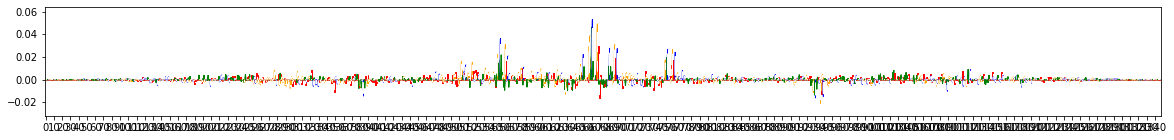

idx 9574
Counts [1107. 1125.]
oneovertemp 1.0
(1000, 2)


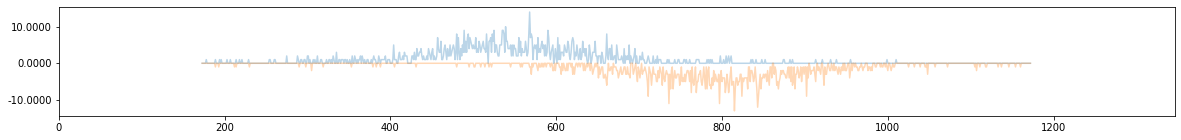

counts imp


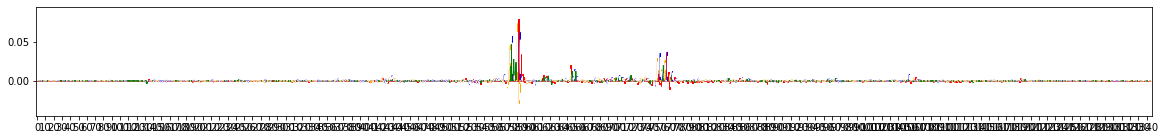

profile imp


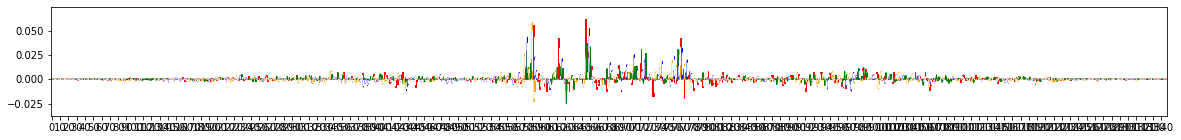

idx 7717
Counts [1133. 1046.]
oneovertemp 1.0
(1000, 2)


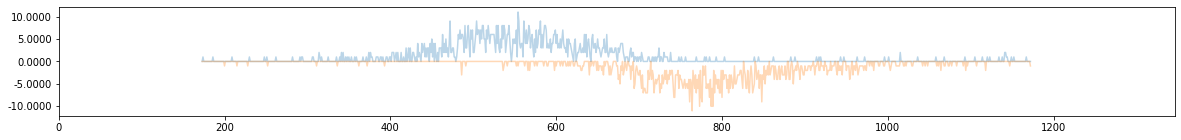

counts imp


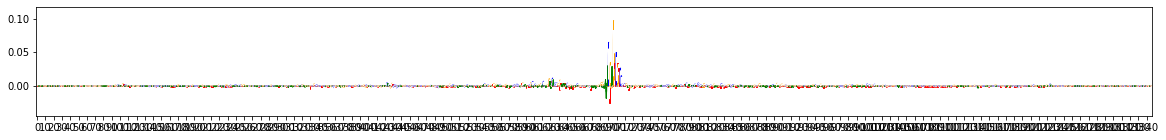

profile imp


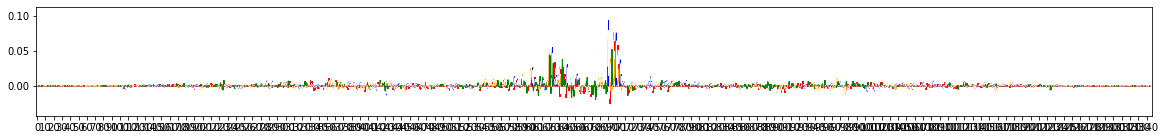

idx 15924
Counts [ 957. 1010.]
oneovertemp 1.0
(1000, 2)


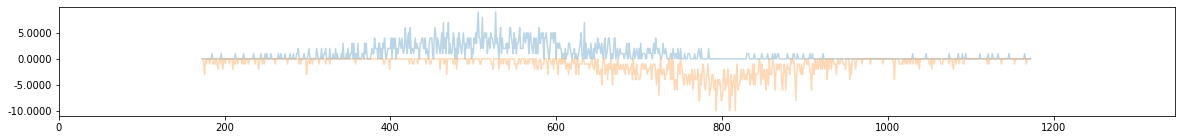

counts imp


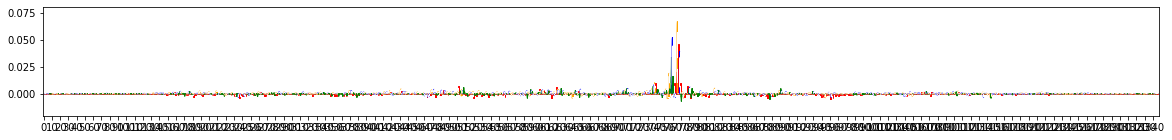

profile imp


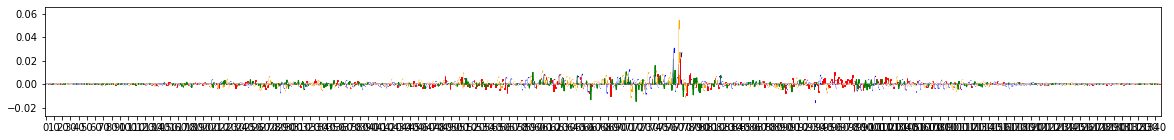

In [12]:
from deeplift.visualization import viz_sequence
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def smooth(vals):
    return np.convolve(vals, np.ones(1,)/1, mode='same')

for i,idx in enumerate(sorted_test_indices[:5]): 
    true_profile = test_labels_profile[idx] 
    print("idx",idx)
    print("Counts",np.sum(true_profile,axis=0))
    
    for oneovertemp in [1.0]:
        print("oneovertemp",oneovertemp)
        print(test_labels_profile[idx].shape)  
        plt.figure(figsize=(20,2))

        start_view = 0
        end_view = seq_len
        total_flanking = seq_len - out_pred_len
        left_flank = int(0.5*total_flanking)
        right_flank = total_flanking - left_flank
        plt.plot(np.arange(out_pred_len)+left_flank, smooth(true_profile[:,0]), alpha=0.3)
        plt.plot(np.arange(out_pred_len)+left_flank, -smooth(true_profile[:,1]), alpha=0.3)
        plt.xlim(start_view,end_view)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        plt.show()

    print("counts imp")
    viz_sequence.plot_weights(post_counts_actualimps[i][start_view:end_view],
                            subticks_frequency=10)
    print("profile imp")
    viz_sequence.plot_weights(post_profile_actualimps[i][start_view:end_view],
                            subticks_frequency=10)

In [13]:
centered_counts_imps = []
centered_profile_imps = []
for idx in range(0,len(new_seqs)):
    center_counts = np.argmax(np.max(post_counts_actualimps[idx], axis=1))
    center_profile = np.argmax(np.max(post_profile_actualimps[idx], axis=1))
    centered_counts_imps.append(post_counts_actualimps[idx][center_counts-100:center_counts+100])
    centered_profile_imps.append(post_profile_actualimps[idx][center_profile-100:center_profile+100])
centered_counts_imps = np.array(centered_counts_imps)
centered_profile_imps = np.array(centered_profile_imps)

counts imp


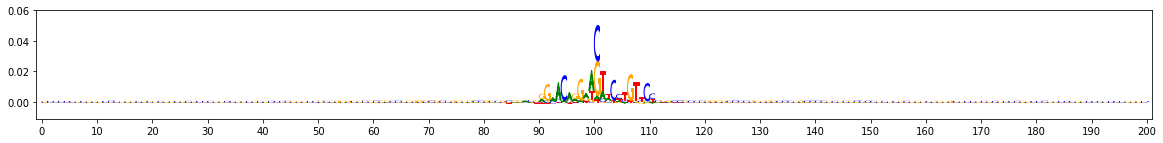

profile imp


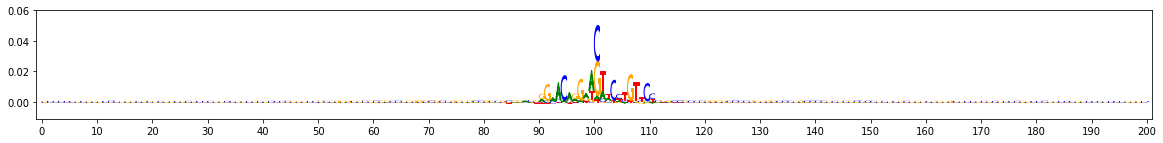

In [14]:
print("counts imp")
viz_sequence.plot_weights(np.mean(centered_counts_imps, axis=0), subticks_frequency=10)
print("profile imp")
viz_sequence.plot_weights(np.mean(centered_counts_imps, axis=0),subticks_frequency=10)

In [27]:
mag_counts_imps = []
mag_profile_imps = []
for idx in range(0,len(new_seqs)):
    center_counts = np.argmax(np.max(post_counts_actualimps[idx], axis=1))
    center_profile = np.argmax(np.max(post_profile_actualimps[idx], axis=1))
    count_scores = np.sum(post_counts_actualimps[idx], axis = 1)[center_counts-100:center_counts+100]
    profile_scores = np.sum(post_profile_actualimps[idx], axis = 1)[center_profile-100:center_profile+100]
    if len(profile_scores) != 200: continue
    mag_counts_imps.append(count_scores)
    mag_profile_imps.append(profile_scores)
mag_counts_imps = np.array(mag_counts_imps)
mag_profile_imps = np.array(mag_profile_imps)

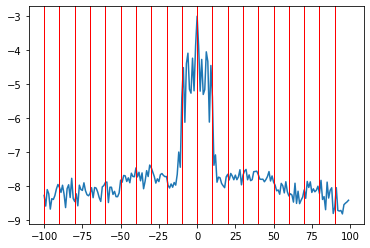

In [16]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(mag_counts_imps, axis=0)))
for vline in np.arange(-100, 100, 10):
    plt.axvline(x=vline, color='red', linewidth=1.0)

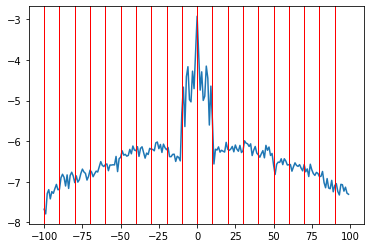

In [29]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(mag_profile_imps, axis=0)))
for vline in np.arange(-100, 100, 10):
    plt.axvline(x=vline, color='red', linewidth=1.0)

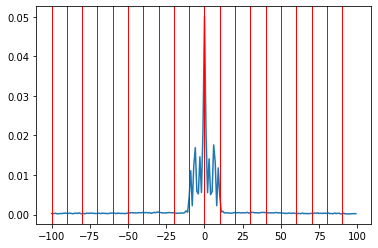

In [17]:
plt.plot(np.arange(-100,100,1), np.mean(mag_counts_imps, axis=0))
for vline in np.arange(-100, 100, 10):
    plt.axvline(x=vline, color='red', linewidth=1.0)

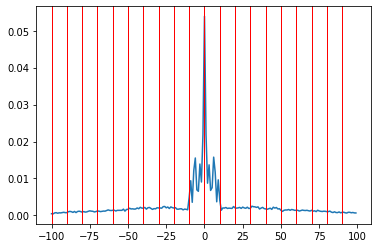

In [30]:
plt.plot(np.arange(-100,100,1), np.mean(mag_profile_imps, axis=0))
for vline in np.arange(-100, 100, 10):
    plt.axvline(x=vline, color='red', linewidth=1.0)